In [1]:
import numpy as np
import scipy
import time
import math
from scipy.stats import norm

import mystic
from mystic.solvers import DifferentialEvolutionSolver, diffev2
from mystic.strategy import Best1Bin
from mystic.monitors import Monitor,VerboseMonitor

from copy import deepcopy

from Tomography import *

from NestedForLoop import get_iterator
from pathlib import Path
from scipy.linalg import sqrtm

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import os
import glob

import pandas as pd

from scipy.optimize import least_squares

import fnmatch

In [2]:
# Order and names in the pseudocode
# x=(22.5,0) y=(0,-45) z=(0,0) a=(45,0)
# Channels: 1 2 3 4 13 14 23 24

## Matching the datafile name with the respective input and measurement basis
MBasisList=['x','y','z'] #in order: D L H

BasesO=['DD','DL','DH','LD','LL','LH', 'HD','HL', 'HH']

In [3]:
def FindingFile(containing, filenames):
    for file in filenames:
         if fnmatch.fnmatch(file, 'Bigiteration_0_'+containing+'_*'):
            return file
    print('No file containing: Bigiteration_0_', containing, '...')
    pass

In [4]:
### Getting the number of necessary files
n_files=0
working_dir=r"G:\Other computers\Mon ordinateur\ChannelCertification\SteeringHonest"
os.chdir(working_dir)

filenames = [i for i in glob.glob("Channel*")]
filenames.sort(key=os.path.getmtime)
for index, filename in enumerate(filenames):
    os.chdir(working_dir+'\\'+filename)
    filenames_aux=[i for i in glob.glob("StateTomography*")]
    for index_second, filenames_aux_second in enumerate(filenames_aux):
        n_files+=1
        print

In [23]:
working_dir=r"G:\Other computers\Mon ordinateur\ChannelCertification\SteeringHonest"

os.chdir(working_dir+'\ChannelSTSteeringHonest202205241718\StateTomography202205241843AfterChannel\StateTomo')
datafiles=[i for i in glob.glob("*")]

##################### STATE TOMOGRAPHY ##############################

##Calculating the efficiencies of each detector
eff=np.array(['zz', 'za', 'az', 'aa'])
for w in range(4):
    file=FindingFile(eff[w], datafiles)
    with open(file) as file:
        
        efficiencies1=np.zeros(4, dtype=float)
        efficiencies2=np.zeros(8, dtype=float)
        
        for line in file:
            fields = line.split()
            for iter, field in enumerate(fields[4:8]):
            #for iter in range (len(fields[4:8])):
                efficiencies1[iter]+=float(float(field))#fields[iter])
            for iter in range (len(fields)-7):
                efficiencies2[iter]+=float(fields[iter])
print('\n Eff: ', efficiencies1/np.max(efficiencies1))
print('\n Eff: ', efficiencies2[4:]/np.max(efficiencies2[4:]))
    



 Eff:  [0.96624725 0.00352586 0.00391758 1.        ]

 Eff:  [0.96624725 0.00352586 0.00391758 1.        ]


In [6]:
working_dir=r"G:\Other computers\Mon ordinateur\ChannelCertification\SteeringHonest"
os.chdir(working_dir)

filenames = [i for i in glob.glob("Channel*")]
filenames.sort(key=os.path.getmtime)

mbasis_number=6

qubit_number=2
numberofchannels=8

dirinv=np.zeros((n_files,2**qubit_number,2**qubit_number), dtype=complex)

Pauli=np.asarray([
        [[1,0],
        [0,1]],


        [[0,1],
        [1,0]],


        [[0,-1j],
        [1j,0]],


        [[1,0],
        [0,-1]]])

tomo_n=0
for index, filename in enumerate(filenames):
    os.chdir(working_dir+'\\'+filename)
    filenames_aux=[i for i in glob.glob("StateTomography*")]
    #filenames_aux=filenames_aux[1:]
    for index_second, filenames_aux_second in enumerate(filenames_aux):
        print(index, filenames_aux_second)
        os.chdir(working_dir+'\\'+filename+'\\'+filenames_aux_second+'\\'+'StateTomo')
        datafiles=[i for i in glob.glob("*")]
        
        counts=np.zeros((numberofchannels,3**qubit_number), dtype=int)
        counts_aux=np.zeros((2**qubit_number,3**qubit_number), dtype=float)
        heralding_single=np.zeros((3**qubit_number), dtype=int)
        xp_counts=np.zeros((3**qubit_number,2**qubit_number), dtype=int)
        efficiencies=np.zeros(8, dtype=float)
        expectations=np.zeros(3, dtype=float)

        ##################### STATE TOMOGRAPHY ##############################

        ##Calculating the efficiencies of each detector
        eff=np.array(['zz', 'za', 'az', 'aa'])
        for w in range(4):
            file=FindingFile(eff[w], datafiles)
            with open(file) as file: 
                for line in file:
                    fields = line.split()
                    #for iter, field in enumerate(fields[4:8]):
                    for iter in range (len(fields)-7):
                        efficiencies[iter]+=float(fields[iter])
            #print('Base, counts', w, fields)


        ### Simulated counts using Simon's tomography functions
        # data is saved as "Bigiteration_0_xy" with x(y) being the measurement(input) basis
        # H is channels 2 and 3
        bases=np.array(['xx', 'xy', 'xz', 'yx', 'yy', 'yz', 'zx', 'zy', 'zz'])#, ## order: D, L, H



        ### Opening the data files and writing the data in counts_aux array
        for w in range(3**qubit_number):
            file=FindingFile(bases[w], datafiles)
            with open(file) as file: 
                for line in file:
                    fields = line.split()
                    for iter in range (len(fields)-7):
                        # In counts[a][b][c][d], 'a' corresponds to the channel (in order): 1 2 3 4 13 14 23 24 (defined in pseudo)
                        counts[iter][w]=fields[iter]

            counts_aux[0][w]=counts[-2][w]
            counts_aux[1][w]=counts[-1][w]
            counts_aux[2][w]=counts[-4][w]
            counts_aux[3][w]=counts[-3][w]
            #heralding_single[w]=counts[3][w]

        ### Normalizing the counts with the detectors efficiencies
        efficiencies=efficiencies[4:8]/np.max(efficiencies[4:8])
        aux=0
        for w in range(3**qubit_number):
           #heralding_single[w]=heralding_single[w]/efficiencies[3]
            counts_aux[0][w]=counts_aux[0][w]/float(efficiencies[2])#*heralding_single[w]*1e-6)
            counts_aux[1][w]=counts_aux[1][w]/float(efficiencies[3])#*heralding_single[w]*1e-6)
            counts_aux[2][w]=counts_aux[2][w]/float(efficiencies[0])#*heralding_single[w]*1e-6)
            counts_aux[3][w]=counts_aux[3][w]/float(efficiencies[1])#*heralding_single[w]*1e-6)
            
            #print('w, Counts: ', w, counts_aux[0][w])

            #if w==0: ## XX expectation value
            #    expectations[0]=(counts_aux[0][w]+counts_aux[3][w]-counts_aux[1][w]-counts_aux[2][w])/(counts_aux[0][w]+counts_aux[1][w]+counts_aux[2][w]+counts_aux[3][w])

            #if w==4: ## YY expectation value
            #    expectations[1]=(counts_aux[0][w]+counts_aux[3][w]-counts_aux[1][w]-counts_aux[2][w])/(counts_aux[0][w]+counts_aux[1][w]+counts_aux[2][w]+counts_aux[3][w])

            #if w==8: ## ZZ expectation value
            #    expectations[2]=(counts_aux[1][w]+counts_aux[2][w]-counts_aux[0][w]-counts_aux[3][w])/(counts_aux[0][w]+counts_aux[1][w]+counts_aux[2][w]+counts_aux[3][w])

            if (aux<(counts_aux[0][w]+counts_aux[1][w]+counts_aux[2][w]+counts_aux[3][w])):
                aux=(counts_aux[0][w]+counts_aux[1][w]+counts_aux[2][w]+counts_aux[3][w])

        ### Sanity check: This prints the normalized number of counts for each measurement basis
        # The total number of counts (considering all output ports of the PBS's) should remain constant (we should see 1 for all of them)
        for w in range(3**qubit_number):
            print('Output basis: ', BasesO[w], '; Sum of counts normalized: ', (counts_aux[0][w]+counts_aux[1][w]+counts_aux[2][w]+counts_aux[3][w])/aux)

        xp_counts[:][:]=np.array(np.transpose(counts_aux[:][:])) # get the experimental counts

        statetomo=LRETomography(int(qubit_number), xp_counts[:][:], 'C:\\Users\\LauraMartins\\Documents\\PhD\\Lab\\Code\\Tomographies')
        statetomo.run(correct_eff=None) ### Runs fast maximum likelihood estimation
        dirinv[tomo_n]=statetomo.quantum_state.get_density_matrix()
        print('\n Fast maximum likelihood estimation: \n', dirinv[tomo_n], '\n')
        tomo_n+=1

0 StateTomography202205241431
Output basis:  DD ; Sum of counts normalized:  1.0
Output basis:  DL ; Sum of counts normalized:  0.9941471239083554
Output basis:  DH ; Sum of counts normalized:  0.9951254310972806
Output basis:  LD ; Sum of counts normalized:  0.9927190907986649
Output basis:  LL ; Sum of counts normalized:  0.9944295764684561
Output basis:  LH ; Sum of counts normalized:  0.9932491169381302
Output basis:  HD ; Sum of counts normalized:  0.9942067307710705
Output basis:  HL ; Sum of counts normalized:  0.99415107426836
Output basis:  HH ; Sum of counts normalized:  0.9997745249547485

 Fast maximum likelihood estimation: 
 [[ 1.67744046e-03+5.14125051e-19j -3.19175496e-03+3.85565181e-03j
   2.84530774e-03-1.54189807e-03j -1.10359875e-05+7.27389251e-04j]
 [-3.19175496e-03-3.85565181e-03j  5.01967965e-01-2.44879207e-19j
  -4.95047782e-01+3.44449026e-03j  5.67884296e-05-2.07955184e-03j]
 [ 2.84530774e-03+1.54189807e-03j -4.95047782e-01-3.44449026e-03j
   4.94426776e-01-2.4

Output basis:  DD ; Sum of counts normalized:  0.997102581031302
Output basis:  DL ; Sum of counts normalized:  0.9948292991380286
Output basis:  DH ; Sum of counts normalized:  0.9956388718049801
Output basis:  LD ; Sum of counts normalized:  0.9985121947706863
Output basis:  LL ; Sum of counts normalized:  1.0
Output basis:  LH ; Sum of counts normalized:  0.9973630821267205
Output basis:  HD ; Sum of counts normalized:  0.9983331203288319
Output basis:  HL ; Sum of counts normalized:  0.9955469692171526
Output basis:  HH ; Sum of counts normalized:  0.998137127802271

 Fast maximum likelihood estimation: 
 [[ 2.08422189e-03-4.68834101e-19j  6.03307450e-03+6.89038091e-04j
   5.68082320e-03-1.12850862e-03j -1.16420031e-04-9.97434918e-04j]
 [ 6.03307450e-03-6.89038091e-04j  4.97590437e-01+5.70400852e-17j
   4.94571719e-01-3.96962165e-03j -5.22033669e-03+9.16664969e-04j]
 [ 5.68082320e-03+1.12850862e-03j  4.94571719e-01+3.96962165e-03j
   4.98350409e-01-5.74546279e-17j -5.44259130e-03-1

Output basis:  DD ; Sum of counts normalized:  0.9987125870881224
Output basis:  DL ; Sum of counts normalized:  0.9978989374433447
Output basis:  DH ; Sum of counts normalized:  0.9944539342754454
Output basis:  LD ; Sum of counts normalized:  0.9999041362321297
Output basis:  LL ; Sum of counts normalized:  1.0
Output basis:  LH ; Sum of counts normalized:  0.998561273164228
Output basis:  HD ; Sum of counts normalized:  0.9926721017820015
Output basis:  HL ; Sum of counts normalized:  0.9894791065929021
Output basis:  HH ; Sum of counts normalized:  0.9932068238838814

 Fast maximum likelihood estimation: 
 [[ 0.49533234+1.95067413e-17j  0.05053886+3.16480692e-03j
  -0.02937885+3.80021038e-02j  0.34413912-3.50702702e-01j]
 [ 0.05053886-3.16480692e-03j  0.00736184+7.95434517e-18j
  -0.00059513+2.24905903e-03j  0.03160327-3.93593988e-02j]
 [-0.02937885-3.80021038e-02j -0.00059513-2.24905903e-03j
   0.00830165-2.34051133e-18j -0.04742569-8.01835552e-03j]
 [ 0.34413912+3.50702702e-01j  


 Fast maximum likelihood estimation: 
 [[ 2.50079919e-03+2.48037644e-19j  9.67852958e-04+7.79135186e-03j
   1.60115991e-03+6.18838084e-03j  4.43463411e-04-1.67785454e-03j]
 [ 9.67852958e-04-7.79135186e-03j  5.00624725e-01-1.32481521e-16j
   4.94224787e-01-3.09135764e-03j -8.68018331e-04-7.45809428e-03j]
 [ 1.60115991e-03-6.18838084e-03j  4.94224787e-01+3.09135764e-03j
   4.94153040e-01+1.31115053e-16j -2.10117916e-03-6.36568401e-03j]
 [ 4.43463411e-04+1.67785454e-03j -8.68018331e-04+7.45809428e-03j
  -2.10117916e-03+6.36568401e-03j  2.72143551e-03+1.11842967e-18j]] 

11 StateTomography202205280838BeforeChannel
Output basis:  DD ; Sum of counts normalized:  0.9961690506827063
Output basis:  DL ; Sum of counts normalized:  0.9915018393591539
Output basis:  DH ; Sum of counts normalized:  0.9967731911334186
Output basis:  LD ; Sum of counts normalized:  0.9882645988365799
Output basis:  LL ; Sum of counts normalized:  0.9911486299175183
Output basis:  LH ; Sum of counts normalized:  0.98

In [48]:
### Fidelity with expectation values
print("Fidelity is: ", (1+np.sum(np.abs(expectations)))/4)

Fidelity is:  0.25


In [14]:
### Functions that will be necessary
def fidelity(ideal, real):
    return (ideal@real@np.transpose(np.conjugate(ideal)))

def GeneralUnitary(x):
    return np.array([[np.exp(1j*x[0])*np.cos(x[2]), np.exp(1j*x[1])*np.sin(x[2])],[-np.exp(-1j*x[1])*np.sin(x[2]), np.exp(-1j*x[0])*np.cos(x[2])]])

def ApplyUnitaryToDM(U, dm):
    return U@dm@np.transpose(np.conjugate(U))

def fUnitary(x, *args):
    U1=GeneralUnitary(x[:3])
    U2=GeneralUnitary(x[3:])
    return -np.abs(fidelity(bell, ApplyUnitaryToDM(np.kron(U1,U2), dirinv[index])))

### Jones formalism representation of a waveplate as a funtion of:
### angle of the WP to the horizontal (t) and the phase difference induced between V and H (n)
def WP_rotation(t, n):
    R= np.exp(-1j*n/2)*np.array([[np.cos(t)**2+np.exp(1j*n)*np.sin(t)**2,(1-np.exp(1j*n))*np.cos(t)*np.sin(t)],
                [(1-np.exp(1j*n))*np.cos(t)*np.sin(t),np.sin(t)**2+np.exp(1j*n)*np.cos(t)**2]])
    return(R)

In [16]:
### Fidelity as a projection

#bell=(np.array([1,0,0,0])+np.array([0,0,0,1]))/np.sqrt(2)
#bell=(np.array([1,0,0,0])-np.array([0,0,0,1]))/np.sqrt(2)
bell=(np.array([0,1,0,0])+np.array([0,0,1,0]))/np.sqrt(2)
#bell=(np.array([0,1,0,0])-np.array([0,0,1,0]))/np.sqrt(2)
bellmatrix=np.array(np.outer(bell, np.conjugate(bell)))

for i in range(n_files):
    print(fidelity(bell, dirinv[i]))

(0.0031495889996556352+2.168404344971009e-19j)
(0.9906966755602378-8.673617379884035e-19j)
(0.04506878630928873+2.7755575615628914e-17j)
(0.9908304370522425+2.862293735361732e-17j)
(0.02349859203625887-2.949029909160572e-17j)
(0.0027220521211596665+3.2526065174565133e-19j)
(0.0033377346163210495-2.168404344971009e-19j)
(0.9925421419327733+3.469446951953614e-18j)
(0.0029048849668170482+1.0842021724855044e-19j)
(0.0038392384684747594-1.4094628242311558e-18j)
(0.9921679340253766+1.3227266504323154e-17j)
(0.0076241730890050695+1.431146867680866e-17j)
(0.9914088123745082+0j)
(0.9922610063972814-8.673617379884035e-19j)
(0.007236615381457376-1.951563910473908e-18j)
(0.013590997129860396-5.204170427930421e-18j)
(0.9914562101236657-2.7755575615628914e-17j)
(0.0155155630034248+6.071532165918825e-18j)
(0.9922076128337314+1.3877787807814457e-17j)
(0.9921118002370175+1.734723475976807e-18j)
(0.041419202506773334+1.214306433183765e-17j)
(0.991613669747736+1.235990476633475e-17j)
(0.00628117407944850

In [28]:
### Optimization of a unitary up to isometry
fid=np.zeros((n_files))
Optimized_matrix=np.zeros((n_files,2**qubit_number,2**qubit_number))
for index in range(n_files):
    result_w=diffev2(fUnitary, x0=np.array([0, 0.4, 0, 0, 0.3, 1.5]), args=dirinv[index], strategy=Best1Bin, bounds=[(-np.pi,np.pi)]*6, npop=50, gtol=100, disp=True, ftol=1e-20, itermon=VerboseMonitor(50), handler=False)
    print('\n The parameters are: ', index, result_w)

    print('\n with a fidelity of: ', -fUnitary(result_w, bellmatrix))

    Unit1=GeneralUnitary(result_w[:3])
    Unit2=GeneralUnitary(result_w[3:])
    print('Unitaries: \n U1=', Unit1, '\n U2=', Unit2)
    Optimized_matrix[index]=ApplyUnitaryToDM(np.kron(Unit1,Unit2), dirinv[index])
    print('\n State after unitaries: \n', Optimized_matrix[index])
    fid[index]=fidelity(bell, Optimized_matrix[index])
    print("\n\n Fidelity is: ", fidelity(bell, Optimized_matrix[index]))

Generation 0 has ChiSquare: -0.001473
Generation 50 has ChiSquare: -0.993265
Generation 100 has ChiSquare: -0.993267
Generation 150 has ChiSquare: -0.993267
Generation 200 has ChiSquare: -0.993267
Generation 250 has ChiSquare: -0.993267
Generation 300 has ChiSquare: -0.993267
Generation 350 has ChiSquare: -0.993267
Generation 400 has ChiSquare: -0.993267
Generation 450 has ChiSquare: -0.993267
STOP("ChangeOverGeneration with {'tolerance': 1e-20, 'generations': 100}")
Optimization terminated successfully.
         Current function value: -0.993267
         Iterations: 470
         Function evaluations: 23550

 The parameters are:  0 [-0.1976765  -0.92256788  0.01329924 -1.77193653  0.69402171 -0.01645386]

 with a fidelity of:  0.9932673967744535
Unitaries: 
 U1= [[ 0.98043883-0.19637424j  0.00802951-0.01060124j]
 [-0.00802951-0.01060124j  0.98043883+0.19637424j]] 
 U2= [[-0.19975963-0.97970678j -0.01264718-0.01052397j]
 [ 0.01264718-0.01052397j -0.19975963+0.97970678j]]

 State after u

C:\Users\LAURAM~1\AppData\Local\Temp/ipykernel_4468/2094743015.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  Optimized_matrix[index]=ApplyUnitaryToDM(np.kron(Unit1,Unit2), dirinv[index])


Generation 50 has ChiSquare: -0.990841
Generation 100 has ChiSquare: -0.990841
Generation 150 has ChiSquare: -0.990841
Generation 200 has ChiSquare: -0.990841
Generation 250 has ChiSquare: -0.990841
Generation 300 has ChiSquare: -0.990841
Generation 350 has ChiSquare: -0.990841
STOP("ChangeOverGeneration with {'tolerance': 1e-20, 'generations': 100}")
Optimization terminated successfully.
         Current function value: -0.990841
         Iterations: 366
         Function evaluations: 18350

 The parameters are:  1 [ 0.62670685  0.85548943 -0.31588836  0.63009862  0.82336059  0.30970928]

 with a fidelity of:  0.9908414762674402
Unitaries: 
 U1= [[ 0.76988691+0.557462j  -0.20374675-0.2345155j]
 [ 0.20374675-0.2345155j  0.76988691-0.557462j ]] 
 U2= [[ 0.76952801+0.56119045j  0.20717854+0.22353742j]
 [-0.20717854+0.22353742j  0.76952801-0.56119045j]]

 State after unitaries: 
 [[ 0.00383393  0.00080681  0.00519707 -0.00163862]
 [ 0.00080681  0.49832601  0.49391077  0.0045689 ]
 [ 0.005

KeyboardInterrupt: 

In [52]:
### ERROR DUE TO WAVEPLATES UNCERTAINTY ###
## In our xp_counts matrix, every entry corresponds to a different projection basis, which is associated to associated to
## a different set of {HWP,QWP}. We need to simulate new number of counts for each entry, given the angle and the
## the uncertainty of the WP's we are using

HWP_dict={"d": np.pi/8,
          "l": 0,
          "v": 0,
          "a": -np.pi/8,
          "r": 0,
          "h": np.pi/4}

QWP_dict={"d": np.pi/2,
          "l": 3*np.pi/4,
          "v": np.pi/2,
          "a": np.pi/2,
          "r": np.pi/4,
          "h": np.pi/2}

projector_dict={"d": np.array([1,1])/np.sqrt(2),
                "l": np.array([1,1j])/np.sqrt(2),
                "v": np.array([1,0]),
                "a": np.array([1,-1])/np.sqrt(2),
                "r": np.array([1,-1j])/np.sqrt(2),
                "h": np.array([0,1])}


ob=np.transpose(np.array([['dd', 'dl', 'dv', 'ld', 'll', 'lh', 'vd', 'vl', 'vv'],
                       ['da', 'dr', 'dh', 'la', 'lr', 'lh', 'va', 'vr', 'vh'],
                       ['ad', 'al', 'av', 'rd', 'rl', 'rv', 'hd', 'hl', 'hv'],
                       ['aa', 'ar', 'ah', 'ra', 'rr', 'rh', 'ha', 'hr', 'hh']]))

lines, columns = np.shape(ob)

In [53]:
### Uncertainty on the WP
sigma_hwp_arya=0.04*np.pi/180
sigma_qwp_arya=0.1*np.pi/180
sigma_hwp_cersei=0.01*np.pi/180
sigma_qwp_cersei=0.11*np.pi/180

In [55]:
### Defining the number of simulated runs
error_runs=1000
mu=np.zeros((n_files))
std=np.zeros((n_files))

for index in range(n_files):
    xp_counts_err=np.zeros((3**qubit_number,2**qubit_number), dtype=int)
    dm_sim_WP=np.zeros((2**qubit_number,2**qubit_number), dtype=complex)

    dm_sim=np.zeros((error_runs, 2**qubit_number,2**qubit_number), dtype=complex)
    dm_err=np.zeros((error_runs, 2**qubit_number,2**qubit_number), dtype=complex)

    fidelity_sim=np.zeros((error_runs), dtype=float)

    ### For each run we simulate the number of counts we could have within poissionian error and calculate
    ### the correspondent density matrix. With each matrix corresponding to an experimental run, we calculate the fidelity
    ### to the Bell state
    for i in range(error_runs):
        for k in range(lines):
            N_total=np.sum(xp_counts[k])
            for l in range(columns):
                proj=['vv', 'vh', 'hv', 'hh']

                proj_basis=ob[k][0]
                angle_hwp_arya=np.random.normal(loc=HWP_dict[proj_basis[0]], scale=sigma_hwp_arya, size=None)
                angle_qwp_arya=np.random.normal(loc=QWP_dict[proj_basis[0]], scale=sigma_qwp_arya, size=None)
                angle_hwp_cersei=np.random.normal(loc=HWP_dict[proj_basis[1]], scale=sigma_hwp_cersei, size=None)
                angle_qwp_cersei=np.random.normal(loc=QWP_dict[proj_basis[1]], scale=sigma_qwp_cersei, size=None)

                r_arya=WP_rotation(angle_qwp_arya,np.pi/2)@WP_rotation(angle_hwp_arya,np.pi)
                r_cersei=WP_rotation(angle_qwp_cersei,np.pi/2)@WP_rotation(angle_hwp_cersei,np.pi)

                ### Here we need to calculate the probability for a given projector and with that calculate N_total
                ### for the xp_counts matrix and then we apply poissonian noise
                MB_change=np.kron(r_arya,r_cersei)

                dm_sim_WP=MB_change@Optimized_matrix[index]@np.transpose(np.conjugate(MB_change))
                proj_basis_array=np.kron(projector_dict[proj[l][0]],projector_dict[proj[l][1]])

                p=proj_basis_array@dm_sim_WP@np.transpose(np.conjugate(proj_basis_array))

                xp_counts_err[k][l]=np.random.poisson(lam=p*N_total)

        statetomo_err=LRETomography(int(qubit_number), xp_counts_err, "C:\\Users\\LauraMartins\\Documents\\PhD\\Lab\\Code\\Tomographies")
        statetomo_err.run() ### Runs fast maximum likelihood estimation
        statetomo_err.quantum_state.get_density_matrix()
        dm_sim[i]=statetomo_err.quantum_state.get_density_matrix()

        fidelity_sim[i]=fidelity(bell, dm_sim[i])
    mu[index], std[index] = norm.fit(fidelity_sim)
    print(mu[index], std[index])

C:\Users\LAURAM~1\AppData\Local\Temp/ipykernel_19384/226639373.py:42: ComplexWarning: Casting complex values to real discards the imaginary part
  xp_counts_err[k][l]=np.random.poisson(lam=p*N_total)
C:\Users\LAURAM~1\AppData\Local\Temp/ipykernel_19384/226639373.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  fidelity_sim[i]=fidelity(bell, dm_sim[i])


0.9931680968002272 0.00012292578718794438
0.9905545468265972 0.0001366071527510643
0.9939222737391815 0.00017916648260442926
0.9907375610191983 0.00019535756805786012
0.991606603808271 0.0002087952714040152
0.9908172005806689 0.00014763175238055405
0.9926914244694938 0.00020782259433740774
0.9835457340352607 9.69076847635209e-05
0.9899552222730094 0.00019091501819593312
0.9923102115455539 4.441597749358403e-05
0.992532234211247 0.0001897823496837621
0.992539792699364 0.0001826374681691692
0.9919580854800918 0.0001663135652039561
0.9921253958170243 9.669974143028959e-05
0.9917685561157368 0.0001517669610303869
0.9915922244854833 0.0001939623697665647
0.9922411615341343 0.00010150440936952848
0.9931744362343404 0.00015769210647497247
0.9932895063496534 0.00013780135126489128
0.991562110570695 0.00014694783843261194
0.9927411098348969 9.983876051102158e-05
0.9924375165368875 8.126476130099767e-05
0.992393963306157 0.00014926682688160082
0.9928003252268497 0.00018386554106511425
0.99164122

In [67]:
import xlsxwriter
working_dir=r"G:\Other computers\Mon ordinateur\ChannelCertification\SteeringHonest"
os.chdir(working_dir)

workbook = xlsxwriter.Workbook('fidelities_errors.xlsx') ### We should write this in another place
 
worksheet = workbook.add_worksheet()

worksheet.write('A1', 'Number')
worksheet.write('B1', 'Folder')
worksheet.write('C1', 'File')
worksheet.write('D1', 'Fidelity')
worksheet.write('E1', 'Uncertainty')
 
# Finally, close the Excel file
# via the close() method.

counter=0
filenames = [i for i in glob.glob("Channel*")]
filenames.sort(key=os.path.getmtime)
for index, filename in enumerate(filenames):
    os.chdir(working_dir+'\\'+filename)
    filenames_aux=[i for i in glob.glob("StateTomography*")]
    for index_second, filenames_aux_second in enumerate(filenames_aux):
        worksheet.write('A'+str(counter+2), counter)
        worksheet.write('B'+str(counter+2),filename)
        worksheet.write('C'+str(counter+2),filenames_aux_second)
        worksheet.write('D'+str(counter+2),np.round(mu[counter],5))
        worksheet.write('E'+str(counter+2),np.round(std[counter],5))
        counter+=1
        
workbook.close()


SyntaxError: unexpected character after line continuation character (Temp/ipykernel_19384/1118112991.py, line 33)

0.9900869320000002 0.00019535625758086188
59.99999999999999 0.9900700000000001 0.00019999999999999998


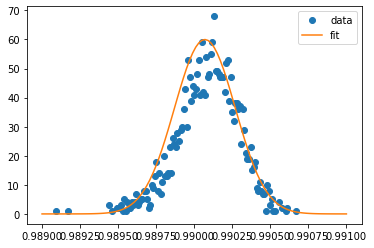

In [192]:
### Then we need to calculate the statistic on these simulated fidelities and calculate the standart deviation
### This will be our uncertainty due to statistical errors
def count_elements(seq) -> dict:
    hist = {}
    for i in seq:
        hist[i] = hist.get(i, 0) + 1
    return hist

counted = count_elements(fidelity_sim)
#print(counted)
bin_numb = len(counted)
errorbar_x=np.array(list(counted))
errorbar_y=np.zeros((bin_numb), dtype=int)

for i in range(bin_numb):
    errorbar_y[i]=counted[errorbar_x[i]]
    
#print(errorbar_x)
#print(errorbar_y)
    
def Gauss(x, A, mu, sigm):
    y = A*np.exp(-((x-mu)/sigm)**2/2)
    return y

mu, std = norm.fit(fidelity_sim)
print(mu, std)
parameters, covariance = curve_fit(Gauss, xdata=errorbar_x[-1], ydata=errorbar_y[:-1], bounds=[(50,0.99007,1e-4),(60,0.9903,0.0002)])
fit_A = parameters[0]
fit_B = parameters[1]
fit_C = parameters[2]
print(fit_A, fit_B, fit_C)

xdata= x = np.linspace(0.989, 0.991, 100)
fit_y = Gauss(xdata, fit_A, fit_B, fit_C)
plt.plot(errorbar_x[:-1], errorbar_y[:-1], 'o', label='data')
plt.plot(xdata, fit_y, '-', label='fit')
plt.legend()